<a href="https://colab.research.google.com/github/hatemamine/impact-Of-Image-Colourspace-On-deep-learning-Convolution-Neural-Networks-Performance/blob/PFE/ResNetCifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Abstract Image classification is fundamental in the field of artificial intelligence, recently Deep Residual Learning [1] and the new coming model CapsulNet[2] have shown state-of-the-art performance for image classification tasks , they takes data-sets mostly as input in the form of RGB images even though we have many other colorspaces available. In this thesis we try to understand the impact of image color-space on the performance of CNN models in Image classification . We evaluate this on CIFAR10 [3]data-set by converting it into five other color-spaces HLS, HSV, LUV, LAB, YUV and trained each one of them in two different deep learning architecture models namely ResNet20 and CapsulNet , the results obtained show a minor change in accuracy but even a small percentage may make the difference, in the other hand LUV is good alternative it show improvement about 0.92% comparison to RGB in ResNet20 and 0.39% in CapsulNet. Keywords: Deep learning, Color-spaces, Convolutional Neural Networks, ResNet, CapsuleNet

Bibliography [1] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” arXiv e-prints, p. arXiv:1512.03385, 2015. [2] S. Sabour, N. Frosst, and G. E Hinton, “Dynamic Routing Between Capsules,” arXiv e- prints, p. arXiv:1710.09829, Oct. 2017. [3] A. K. V. N. G. Hinton, “The CIFAR-10 dataset {https://www.cs.toronto.edu/~kriz/cifar.html}.” 2014. [4] K. S. Reddy, U. Singh, and P. K. Uttam, “Effect of image colourspace on performance of convolution neural networks,” in 2017 2nd IEEE International Conference on Recent Trends in Electronics, Information Communication Technology (RTEICT), 2017, pp. 2001–2005. [5] S. N. Gowda and C. Yuan, “ColorNet: Investigating the importance of color spaces for image classification,” arXiv e-prints, p. arXiv:1902.00267, 2019. [6] “Keras: The Python Deep Learning library {https://keras.io}.” 2019. [7] F. Chollet, Deep learning with Python. Shelter Island, NY: Manning Publications Co, 2018. [8] T. Mitchell, Machine Learning. New York: McGraw-Hill, 1997. [9] Y. LeCun, Y. Bengio, and G. Hinton, “Deep learning,” Nature, vol. 521, no. 7553, p. 436, 2015. [10] N. Buduma, Fundamentals of deep learning : designing next-generation machine intelligence algorithms. Sebastopol, CA: O’Reilly Media, 2017. [11] J. Patterson, Deep learning : a practitioner’s approach. Sebastopol, CA: O’Reilly, 2017. [12] D. E. Rumelhart, G. E. Hinton, R. J. Williams, and others, “Learning representations by back-propagating errors,” Cogn. Model., vol. 5, no. 3, p. 1, 1988. [13] M. A. Wani, Advances in deep learning. Singapore: Springer, 2020. [14] I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning. MIT Press, 2016. [15] W. Burger, Principles of digital image processing : core algorithms. London: Springer, 2009. [16] J. Schanda, Colorimetry : understanding the CIE system. Vienna, Austria Hoboken, N.J: CIE/Commission internationale de l’eclairage Wiley-Interscience, 2007. [17] M. Safdar, G. Cui, Y. Jin Kim, and M. Luo, “Perceptually uniform color space for image signals including high dynamic range and wide gamut,” Opt. Express, vol. 25, p. 15131, 2017. [18] “scikit-image {https://scikit-image.org/}.” 2019. [19] “colorsys module {https://docs.python.org/2/library/colorsys.html}.” 2019.[20] Mart\’\in~Abadi et al., “{TensorFlow}: Large-Scale Machine Learning on Heterogeneous Systems.” 2015. [21] “Train a simple CNN-Capsule Network on the CIFAR10 {https://keras.io/examples/cifar10_cnn_capsule/}.” 2019. [22] “Trains a ResNet on the CIFAR10 dataset {https://keras.io/examples/cifar10_resnet}.” 2019.


In [1]:
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

download('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz','cifar-10-python.tar.gz')
print("All the files are downloaded")#If the downloaded file is a zip file than you can use below function to unzip it.

Download file... cifar-10-python.tar.gz ...
File downloaded
All the files are downloaded


In [2]:
!tar -xvf cifar-10-python.tar.gz	

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
HSLcifar10_normalized.pkl
finish


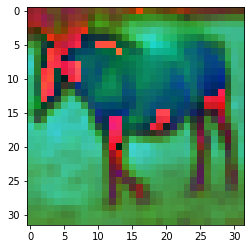

In [6]:
"""
Created on Mon May 20 12:54:13 2019
@author: hatem M'hamed Amine
load CIFAR10 small images classification dataset 
and convert it to the desired color space
"""

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division
import keras
import numpy as np
import pickle
from skimage import io , color
import colorsys
import numpy
import os
from ipywidgets import widgets
from keras.datasets.cifar import load_batch
from keras import backend as K
from ipywidgets import interact
# remove file from kaggle working directory
converted_filenam =''        
def load_data():
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    path = './cifar-10-batches-py'
    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)
"""
https://docs.python.org/2/library/colorsys.html
colorsys.rgb_to_hls(r, g, b)
Convert the color from RGB coordinates to HLS coordinates
It is most common to use 32-bit precision when training a neural network
Regarding the division by 255, this is the maximum value of a byte
so this will ensure that the input features are scaled 
between 0.0 and 1.0
"""

def convertHSL(image):    
    for x in range(0, 32):
        for x1 in range(0, 32):
            image[x][x1][0] ,image[x][x1][1] ,image[x][x1][2]= colorsys.rgb_to_hls(image[x][x1][0] ,image[x][x1][1] ,image[x][x1][2])            
    return image

def srgb2rgb(c):    
    if (c > 0.03928):
       c= ((c + 0.055)/1.055)**2.4 
    else: c= c/12.92   
    return c

#linearized by inverting the gamma correction
def normalised_srgb(image):    
    for x in range(0, 32):
        for x1 in range(0, 32):
            image[x][x1][0] = srgb2rgb(image[x][x1][0])
            image[x][x1][1] = srgb2rgb(image[x][x1][1])
            image[x][x1][2] = srgb2rgb(image[x][x1][2])
    return image


def convert(colorspace='RGB' , subtract_pixelmean=False):
    num_classes = 10
    # Subtracting pixel mean improves accuracy True or False
    subtract_pixel_mean = subtract_pixelmean
        
    # Load the CIFAR10 data.
    (x_train, y_train), (x_test, y_test) = load_data()
    
    # Input image dimensions.
    #input_shape = x_train.shape[1:]

    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    
    
    #conver to HSL
    if colorspace=="HSL" :
        for x in range(x_train.shape[0]):
            x_train[x]=convertHSL(x_train[x])
            
        for x1 in range(x_test.shape[0]):
            x_test[x1]=convertHSL(x_test[x1])

    #conver to HSV
    if colorspace=="HSV" :
        for x in range(x_train.shape[0]):
            x_train[x] = color.rgb2hsv(x_train[x])
            
        for x1 in range(x_test.shape[0]):
            x_test[x1] = color.rgb2hsv(x_test[x1])  
            
    #conver to XYZ
    if colorspace=="XYZ" :
        for x in range(x_train.shape[0]):
            x_train[x] = color.rgb2xyz(x_train[x])          
        for x1 in range(x_test.shape[0]):
            x_test[x1] = color.rgb2xyz(x_test[x1])  
                
        
    #conver to LUV
    if colorspace=="LUV" :
        for x in range(x_train.shape[0]):
            x_train[x] = color.rgb2luv(x_train[x]) 
            
        for x1 in range(x_test.shape[0]):
            x_test[x1] = color.rgb2luv(x_test[x1])  
    #conver to LAB
    if colorspace=="LAB" :
        for x in range(x_train.shape[0]):
            x_train[x] = color.rgb2lab(x_train[x]) 
            
        for x1 in range(x_test.shape[0]):
            x_test[x1] = color.rgb2lab(x_test[x1])  
            
    #conver to YUV
    if colorspace=="YUV" :
        for x in range(x_train.shape[0]):
            x_train[x] = color.rgb2yuv(x_train[x]) 
            
        for x1 in range(x_test.shape[0]):
            x_test[x1] = color.rgb2yuv(x_test[x1])
            
    
    filenam=colorspace
    # If subtract pixel mean is enabled
    if subtract_pixel_mean:
        filenam=filenam+"subtract_pixel_mean"
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean
    
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)
    
    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    filenam = filenam + "cifar10_normalized.pkl"
    print(filenam)
    with open(filenam, 'wb') as f:
        pickle.dump(((x_train, y_train), (x_test, y_test)), f)
    print("finish")
    return filenam
colorspace = 'HSL' #@param ['RGB', 'HSL', 'HSV', 'LAB','LUV','YUV'] {allow-input: true}
subtract_pixel_mean =False #@param {type:"boolean"}
converted_filenam = convert(colorspace, subtract_pixel_mean)




import pickle
import matplotlib.pyplot as plt  
with open(converted_filenam, 'rb') as f:
    (x_train, y_train), (x_test, y_test) = pickle.load(f)    
plt.imshow(x_train[7])
plt.show()
#io.imsave(converted_filenam+'B1_7.png',x_train[7])

In [7]:
print(converted_filenam)

HSLcifar10_normalized.pkl


In [8]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint , TensorBoard
#callbacks=callbacks ,steps_per_epoch=391
import numpy as np
import os
import pickle

#@markdown ### Training parameters

#@markdown ----

#@markdown  orig paper trained all networks with batch_size=128
batch_size = 128 #@param {type:"slider", min:0, max:1024, step:32}

epochs = 90 #@param {type:"slider", min:0, max:200, step:1}

#@title data augmentation improves accuracy
data_augmentation = True #@param {type:"boolean"}
num_classes = 10
savemodel =""

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
# Load the CIFAR10 data.
path=""
with open(path+converted_filenam, 'rb') as f:
    (x_train, y_train), (x_test, y_test) = pickle.load(f) 
# Input image dimensions.
input_shape = x_train.shape[1:]
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)
# Prepare callbacks for model saving and for learning rate adjustment and log tensorboard
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
savemodel = converted_filenam+model_name
checkpoint = ModelCheckpoint(filepath=savemodel,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True , mode='max')



lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

mycallbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=mycallbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history =model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, callbacks=mycallbacks, workers=4)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

from pickle import dump 
with open('History'+savemodel, 'wb') as handle: # saving the history of the model
    dump(history.history, handle)
print("finich")

Learning rate:  0.001
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 16)   64          conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 32, 32, 16)   0           batch_normalization_20[0][0]     
______________________________________________________________________